# Astrometric analysis with ePSF

For details about the simulation assumptions, see ../00_memo.txt.

## Importing some modules

In [1]:
import copy, warnings
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.modeling import models, fitting
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.visualization import simple_norm
from photutils.background import MMMBackground
from photutils.detection import find_peaks
from photutils.psf import EPSFBuilder, extract_stars

## Defining a function

In [2]:
def func(filename, sp_filename, mag, n_maxiter, norm_radius=5.5, recentering_boxsize=5):
    '''
    filename: Name of the input FITS file.
    sp_filename: Name of the input star-plate file.
    mag: Object magnitude.
    n_maxiter: Maximum number of iteration in ePSF analysis.
    norm_radius: Number of undersampled pixels 
                 which determines the radius for flux normalization of ePSF.
    recentering_boxsize: Number of undersampled pixels
                 which determines the box size for ePSF recentering calculation.
    '''
    
    mask_size = 25   # Edge mask size.
    ext_size  = 9    # Size of extraction window.
    n_oversample = 4 # Number of oversampling for ePSF.
#    n_maxiter    = 3 # Max. number of iteration for making ePSF.
#    mag = 12.0       # Object magnitude.
    threshold = 3000.*10.**((mag-12.0)/(-2.5))
#    print("Analyzing {}...".format(filename))
    
    # Loading image.
    hdu = pf.open(filename)[0]
    data = hdu.data.astype(np.float32)
    norm = simple_norm(data, 'sqrt', percent=99.)
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.show()
    
    # Finding peaks.
    peaks_tbl = find_peaks(data, threshold=threshold)
    peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
#    print(peaks_tbl)
    
    # Removing detections near edge.
    hsize = (mask_size - 1) / 2
    x = peaks_tbl['x_peak'] 
    y = peaks_tbl['y_peak'] 
    mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]
#    print(stars_tbl)
    
    # Subtracting background.
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
    image = copy.deepcopy(data)
    data -= mean_val
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')

    # Extracting stellar images.
    nddata = NDData(data=data)
#    print(nddata.data.shape)
    stars = extract_stars(nddata, stars_tbl, size=ext_size)
#    nrows = 10
#    ncols = 10
#    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
#    ax = ax.ravel()
#    for i in range(nrows*ncols):
#        norm = simple_norm(stars[i], 'log', percent=99.)
#        ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
#    plt.show()
        
    # Making ePSF.
    epsf_builder = EPSFBuilder(oversampling=n_oversample,
                               maxiters=n_maxiter, progress_bar=False,
                               norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                               center_accuracy=0.001)
    epsf, fitted_stars = epsf_builder(stars)
    norm = simple_norm(epsf.data, 'log', percent=99.)
    plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
    plt.xlabel('X (oversampled pix)')
    plt.ylabel('Y (oversampled pix)')
    plt.colorbar()
    plt.show()

    # Loading stellar-plate data.
    original = np.loadtxt(sp_filename,skiprows=1,delimiter=",")
    
    # Cross-checking the data.
    xc_array = []
    for o in original:
        diff = fitted_stars.center_flat-np.array([o[2],o[3]])
        p = np.where(diff[:,0]**2.+diff[:,1]**2.<10.**2.)
        if np.size(p) == 1:
            xc_array.append([o[2]-1., o[3]-1.,      # 1-origin -> 0-origin
                             fitted_stars.center_flat[p[0][0]][0],
                             fitted_stars.center_flat[p[0][0]][1]])
    xc_array = np.array(xc_array)
#    print(xc_array)
    
    # Making dx/dy data.
    dx = xc_array[:,2] - xc_array[:,0]
    dy = xc_array[:,3] - xc_array[:,1]
#    dx = dx - np.mean(dx)
#    dy = dy - np.mean(dy)
    plt.scatter(dx, dy, marker='x')
    plt.xlabel('$\Delta$x (px)')
    plt.ylabel('$\Delta$y (px)')
    plt.xlim([-0.01,0.04])
    plt.ylim([-0.01,0.04])
    plt.show()
    
    # Making pix-phase error data.
    plt.scatter(xc_array[:,0]-(xc_array[:,0]+0.5).astype('int'), dx, marker='x', label='X')
    plt.scatter(xc_array[:,1]-(xc_array[:,1]+0.5).astype('int'), dy, marker='x', label='Y')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.01,0.04])
    plt.xlabel('Pixel phase')
    plt.ylabel('Deviation (px)')
    plt.legend()
    plt.show()
    
#    plt.axes().set_aspect('equal')
#    plt.quiver(xc_array[:,2], xc_array[:,3], dx, dy,
#               angles='xy', scale_units='xy', scale=0.0003)
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.xlim([0, 1920])
#    plt.ylim([0, 1920])
#    plt.show()
    
    # Calculating stddev.
#    print("STDDEV DX: {} px".format(np.std(dx)))
#    print("STDDEV DY: {} px".format(np.std(dy)))
    stddx = np.std(dx)
    stddy = np.std(dy)
#    stddr = np.std(np.sqrt(dx*dx+dy*dy))
    
    meandx = np.mean(dx)
    meandy = np.mean(dy)
    
    stddr = np.std(np.sqrt((dx-meandx)**2.+(dy-meandy)**2.))
    return stddx, stddy, stddr, meandx, meandy

## Number of iterations and positional deviations

We check the changes of the created ePSF and positional deviations in the iteration. We analyze image.12.0.00.fits, here.

Iteration 1...


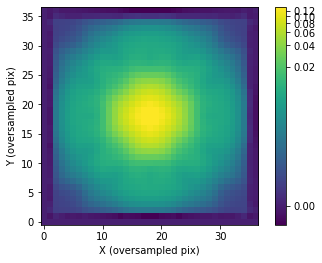

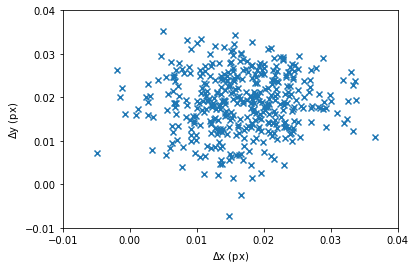

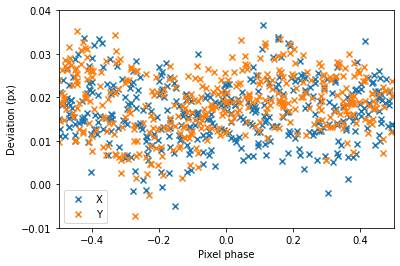

Iteration 2...


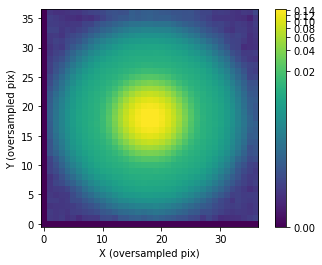

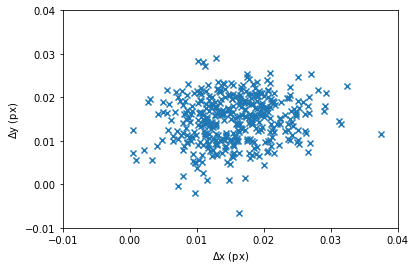

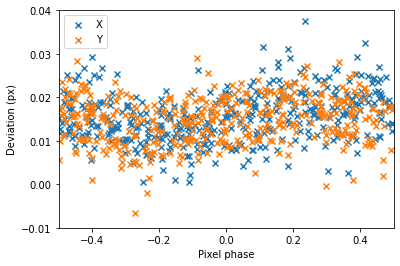

Iteration 3...


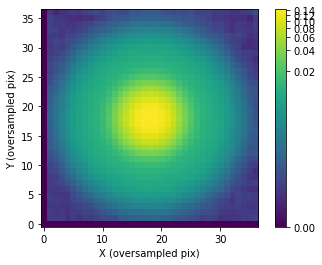

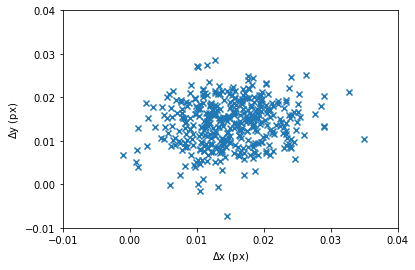

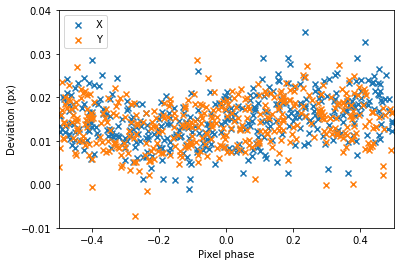

Iteration 4...


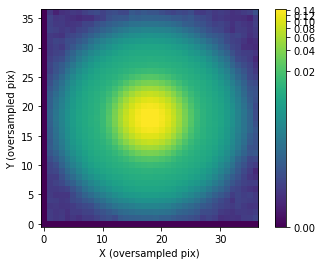

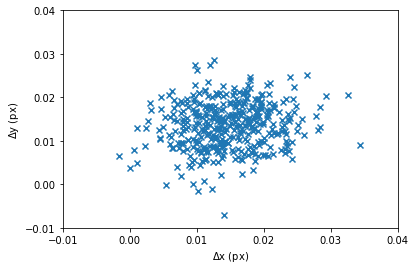

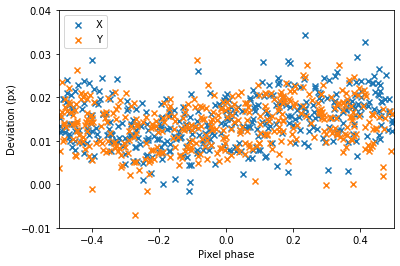

Iteration 5...


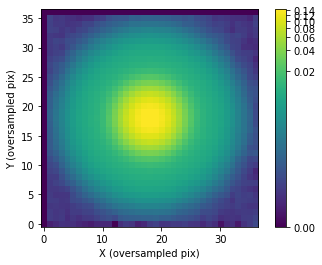

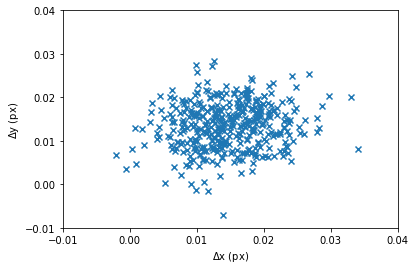

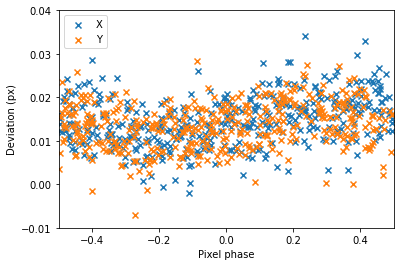

Iteration 6...


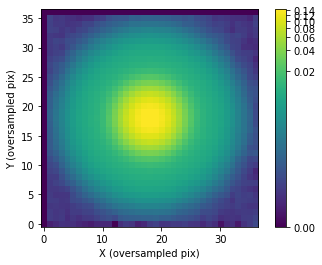

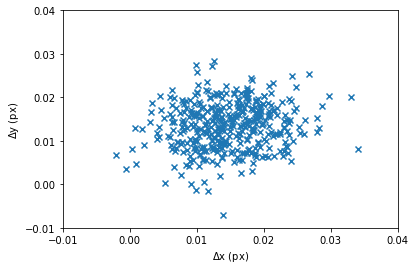

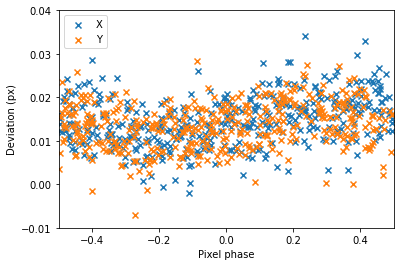

Iteration 7...


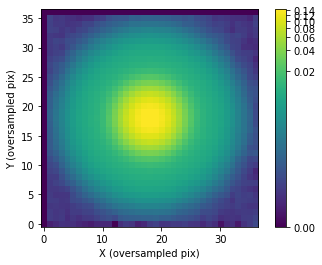

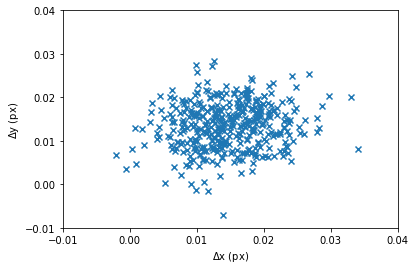

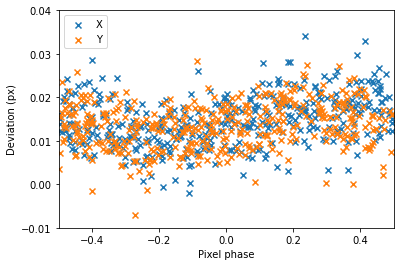

Iteration 8...


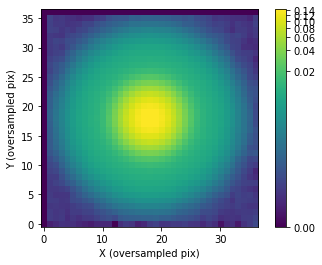

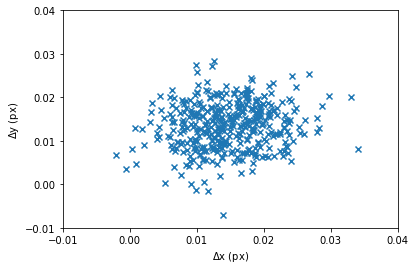

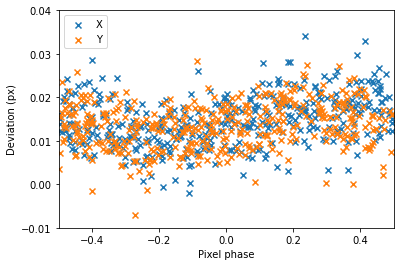

Iteration 9...


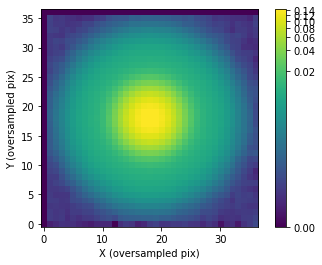

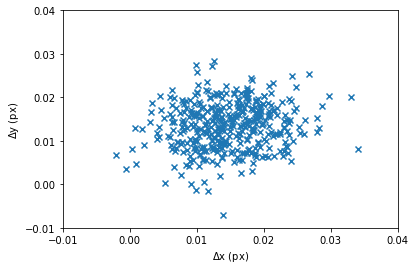

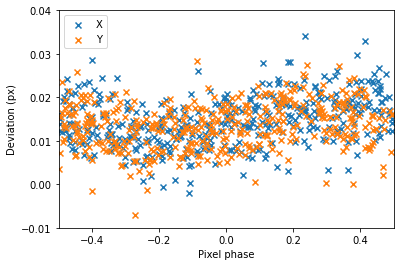

Iteration 10...


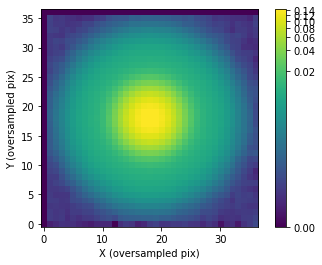

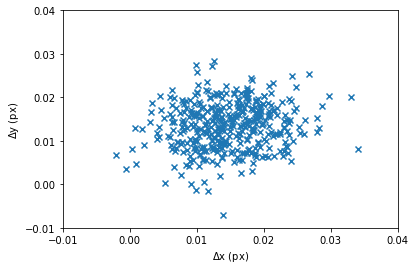

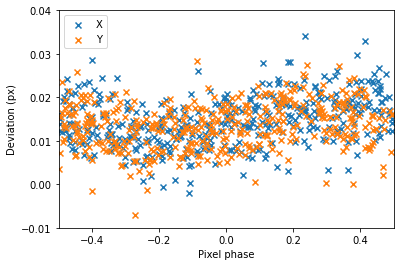

[0.004448282146425231, 0.0035870131600274505, 0.003540818742529429, 0.00356599701333874, 0.0036058480487823757, 0.0036058480487823757, 0.0036058480487823757, 0.0036058480487823757, 0.0036058480487823757, 0.0036058480487823757]


In [3]:
sra=[]
tmp = []
for i in range(1,11):
    print("Iteration {}...".format(i))
    sx, sy, sr, mx, my = func("image.12.0.00.fits",
                              "../01_params/spcsv_20_1920_10_20_12.0.csv", 12.0, i, norm_radius=5.5, recentering_boxsize=5)
    tmp.append(sr)
print(tmp)

The iteration is stopped after the fifth iteration when the position_accuracy parameter is set to 0.001. After the third iteration, the deviation increases.

Next, we examine the 14.5-mag data.

Iteration 1...


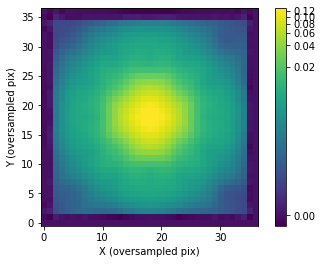

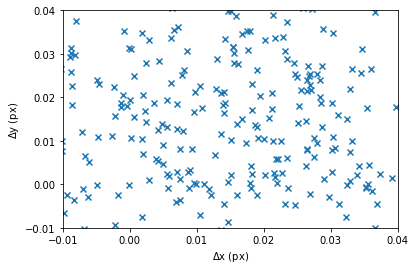

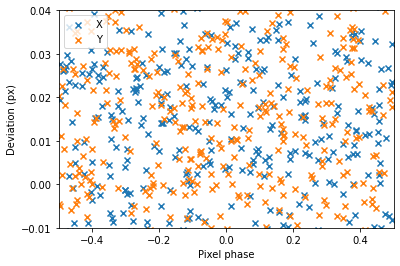

Iteration 2...


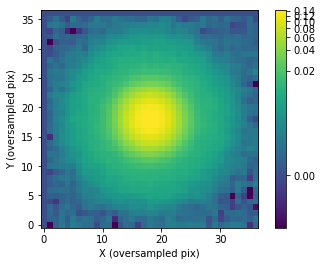

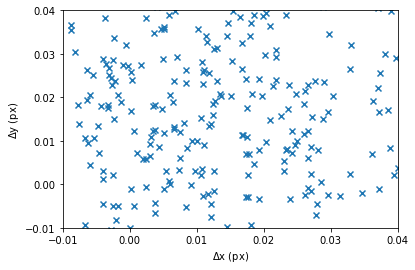

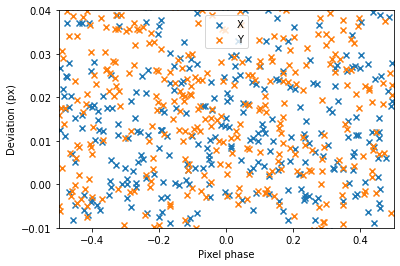

Iteration 3...


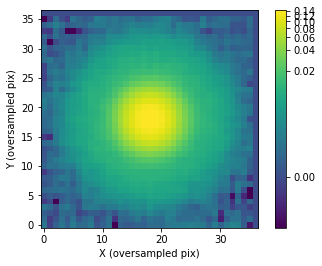

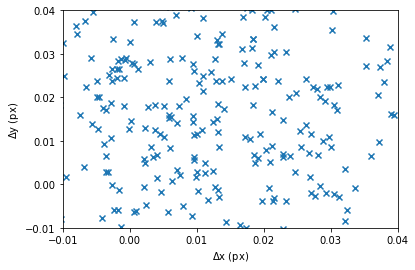

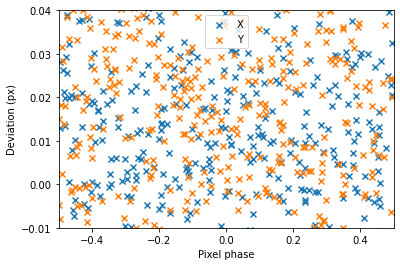

Iteration 4...


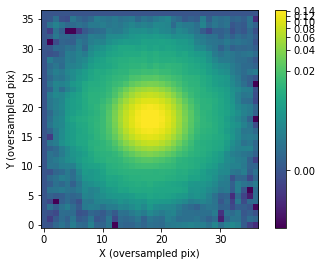

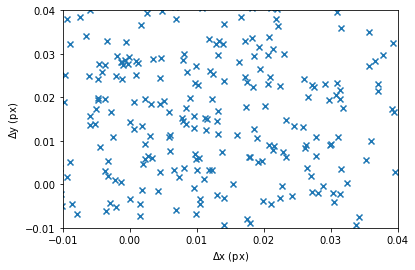

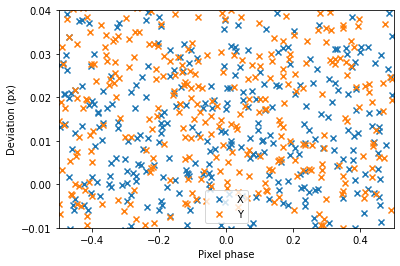

Iteration 5...


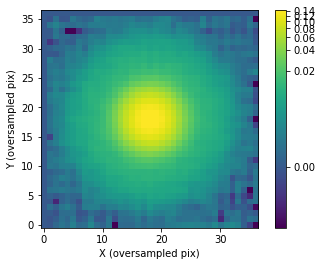

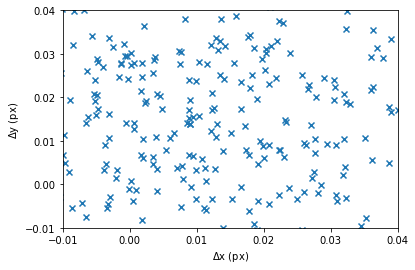

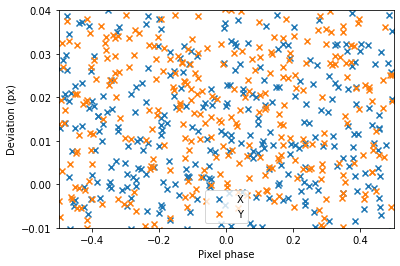

Iteration 6...


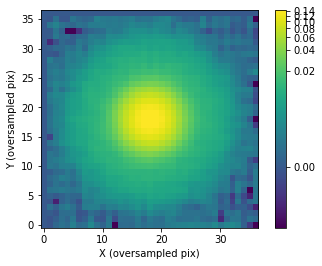

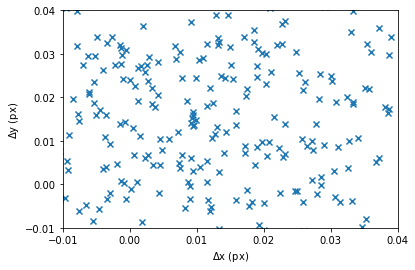

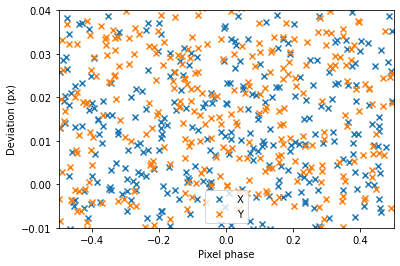

Iteration 7...


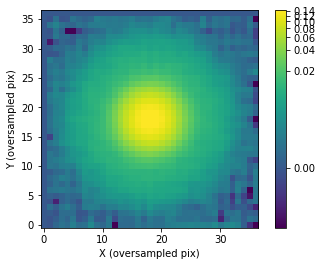

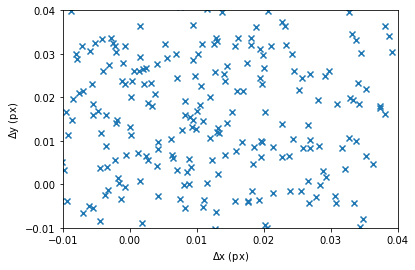

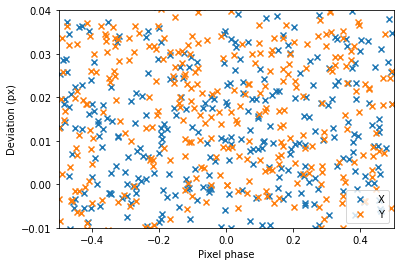

Iteration 8...


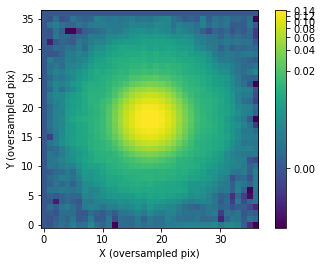

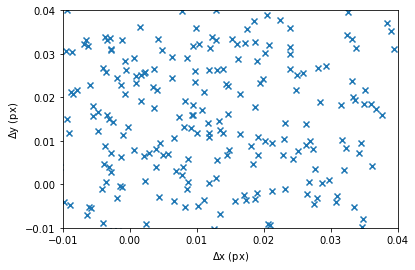

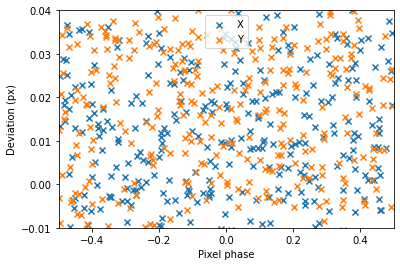

Iteration 9...


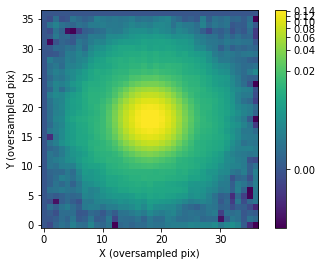

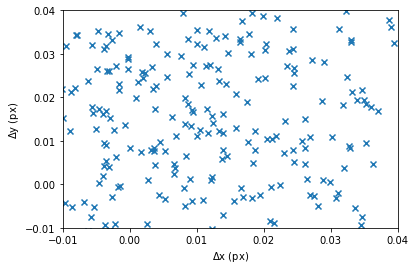

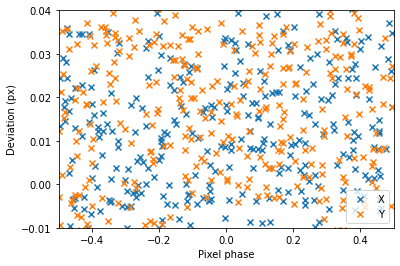

Iteration 10...


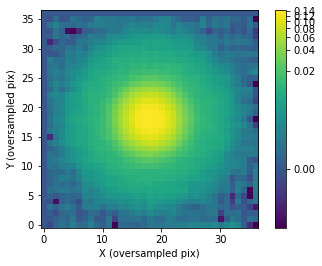

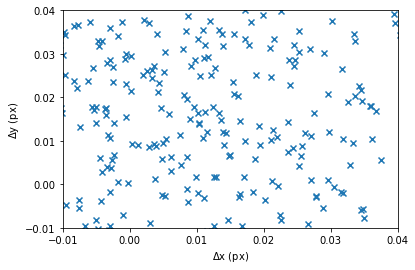

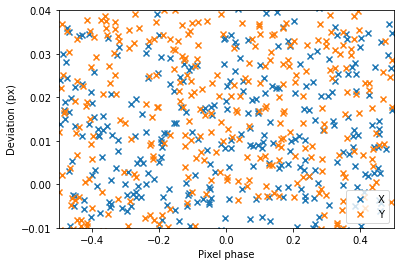

[0.014362034249408389, 0.013874578705946404, 0.013863339592212524, 0.013901494819152142, 0.013941436820594788, 0.013999315141425868, 0.014061235520522372, 0.014162000948885456, 0.014249257954147188, 0.014339463710837504]


In [4]:
sra=[]
tmp = []
for i in range(1,11):
    print("Iteration {}...".format(i))
    sx, sy, sr, mx, my = func("image.14.5.00.fits",
                              "../01_params/spcsv_20_1920_10_20_12.0.csv", 14.5, i, norm_radius=5.5, recentering_boxsize=5)
    tmp.append(sr)
print(tmp)

After the third iteration, the deviation increases. The appropriate value for maxiter seems to be 3.

In [5]:
def func(filename, sp_filename, mag, n_maxiter=3, norm_radius=5.5, recentering_boxsize=5):
    '''
    filename: Name of the input FITS file.
    sp_filename: Name of the input star-plate file.
    mag: Object magnitude.
    n_maxiter: Maximum number of iteration in ePSF analysis.
    norm_radius: Number of undersampled pixels 
                 which determines the radius for flux normalization of ePSF.
    recentering_boxsize: Number of undersampled pixels
                 which determines the box size for ePSF recentering calculation.
    '''
    
    mask_size = 25   # Edge mask size.
    ext_size  = 9    # Size of extraction window.
    n_oversample = 4 # Number of oversampling for ePSF.
#    n_maxiter    = 3 # Max. number of iteration for making ePSF.
#    mag = 12.0       # Object magnitude.
    threshold = 3000.*10.**((mag-12.0)/(-2.5))
#    print("Analyzing {}...".format(filename))
    
    # Loading image.
    hdu = pf.open(filename)[0]
    data = hdu.data.astype(np.float32)
    norm = simple_norm(data, 'sqrt', percent=99.)
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.show()
    
    # Finding peaks.
    peaks_tbl = find_peaks(data, threshold=threshold)
    peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
#    print(peaks_tbl)
    
    # Removing detections near edge.
    hsize = (mask_size - 1) / 2
    x = peaks_tbl['x_peak'] 
    y = peaks_tbl['y_peak'] 
    mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]
#    print(stars_tbl)
    
    # Subtracting background.
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
    image = copy.deepcopy(data)
    data -= mean_val
#    plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')

    # Extracting stellar images.
    nddata = NDData(data=data)
#    print(nddata.data.shape)
    stars = extract_stars(nddata, stars_tbl, size=ext_size)
#    nrows = 10
#    ncols = 10
#    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
#    ax = ax.ravel()
#    for i in range(nrows*ncols):
#        norm = simple_norm(stars[i], 'log', percent=99.)
#        ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
#    plt.show()
        
    # Making ePSF.
    epsf_builder = EPSFBuilder(oversampling=n_oversample,
                               maxiters=n_maxiter, progress_bar=False,
                               norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                               center_accuracy=0.001)
    epsf, fitted_stars = epsf_builder(stars)
#    norm = simple_norm(epsf.data, 'log', percent=99.)
#    plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
#    plt.xlabel('X (oversampled pix)')
#    plt.ylabel('Y (oversampled pix)')
#    plt.colorbar()
#    plt.show()

    # Loading stellar-plate data.
    original = np.loadtxt(sp_filename,skiprows=1,delimiter=",")
    
    # Cross-checking the data.
    xc_array = []
    for o in original:
        diff = fitted_stars.center_flat-np.array([o[2],o[3]])
        p = np.where(diff[:,0]**2.+diff[:,1]**2.<10.**2.)
        if np.size(p) == 1:
            xc_array.append([o[2]-1., o[3]-1.,      # 1-origin -> 0-origin
                             fitted_stars.center_flat[p[0][0]][0],
                             fitted_stars.center_flat[p[0][0]][1]])
    xc_array = np.array(xc_array)
#    print(xc_array)
    
    # Making dx/dy data.
    dx = xc_array[:,2] - xc_array[:,0]
    dy = xc_array[:,3] - xc_array[:,1]
#    dx = dx - np.mean(dx)
#    dy = dy - np.mean(dy)
    plt.scatter(dx, dy, marker='x')
    plt.xlabel('$\Delta$x (px)')
    plt.ylabel('$\Delta$y (px)')
    plt.xlim([-0.01,0.04])
    plt.ylim([-0.01,0.04])
    plt.show()
    
    # Making pix-phase error data.
    plt.scatter(xc_array[:,0]-(xc_array[:,0]+0.5).astype('int'), dx, marker='x', label='X')
    plt.scatter(xc_array[:,1]-(xc_array[:,1]+0.5).astype('int'), dy, marker='x', label='Y')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
    plt.xlim([-0.5,0.5])
    plt.ylim([-0.01,0.04])
    plt.xlabel('Pixel phase')
    plt.ylabel('Deviation (px)')
    plt.legend()
    plt.show()
    
#    plt.axes().set_aspect('equal')
#    plt.quiver(xc_array[:,2], xc_array[:,3], dx, dy,
#               angles='xy', scale_units='xy', scale=0.0003)
#    plt.xlabel('X (px)')
#    plt.ylabel('Y (px)')
#    plt.xlim([0, 1920])
#    plt.ylim([0, 1920])
#    plt.show()
    
    # Calculating stddev.
#    print("STDDEV DX: {} px".format(np.std(dx)))
#    print("STDDEV DY: {} px".format(np.std(dy)))
    stddx = np.std(dx)
    stddy = np.std(dy)
#    stddr = np.std(np.sqrt(dx*dx+dy*dy))
    
    meandx = np.mean(dx)
    meandy = np.mean(dy)
    
    stddr = np.std(np.sqrt((dx-meandx)**2.+(dy-meandy)**2.))
    return stddx, stddy, stddr, meandx, meandy, np.size(dx)

image.12.0.00.fits


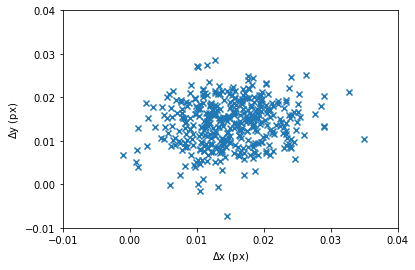

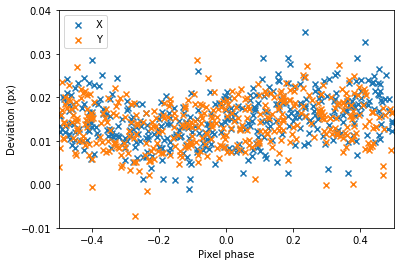

image.12.0.01.fits


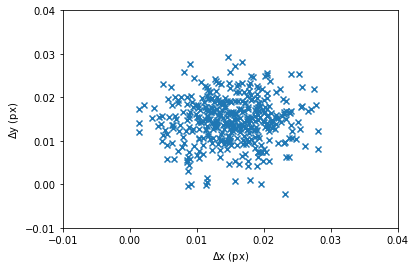

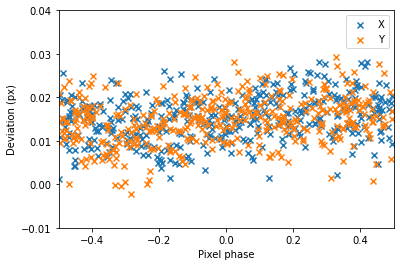

image.12.0.02.fits


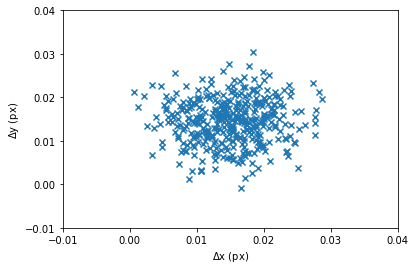

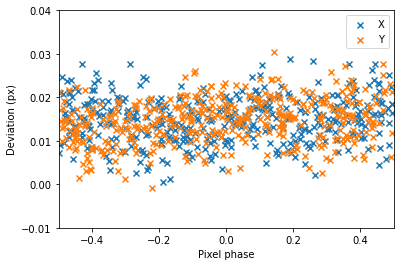

image.12.0.03.fits


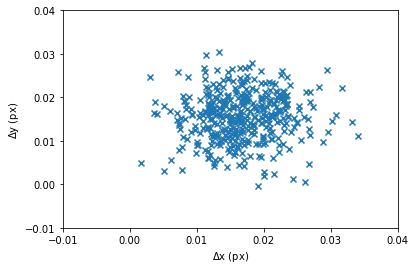

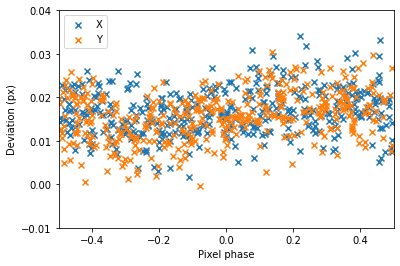

image.12.0.04.fits


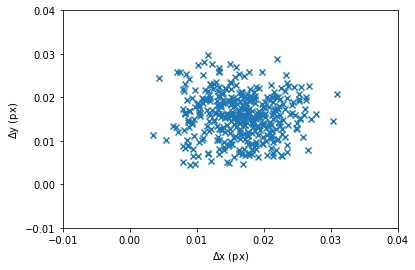

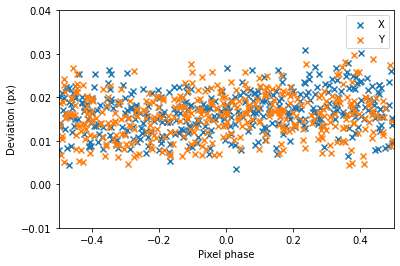

image.12.0.05.fits


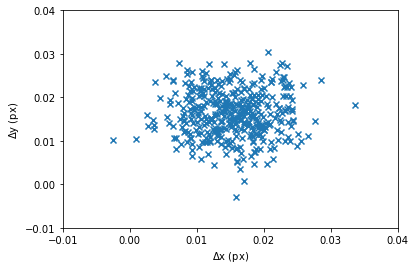

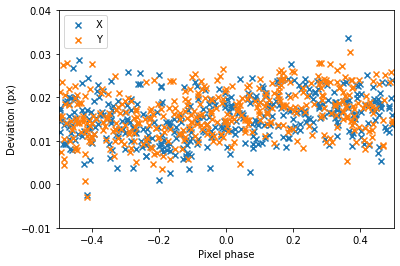

image.12.0.06.fits


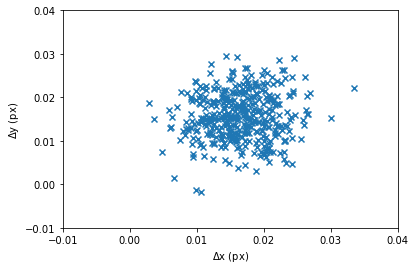

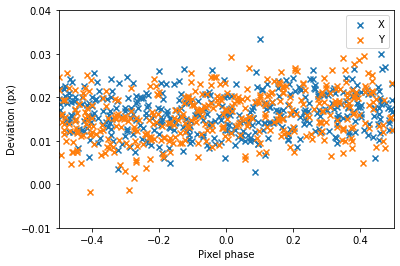

image.12.0.07.fits


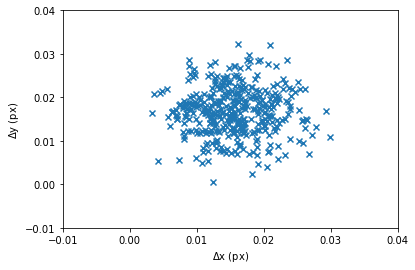

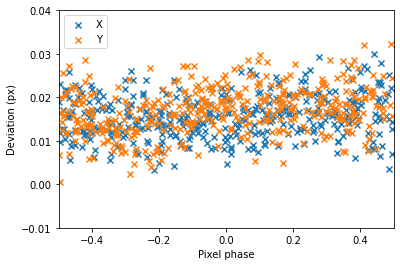

image.12.0.08.fits


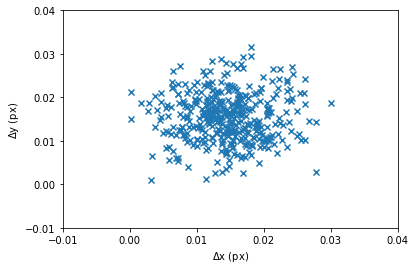

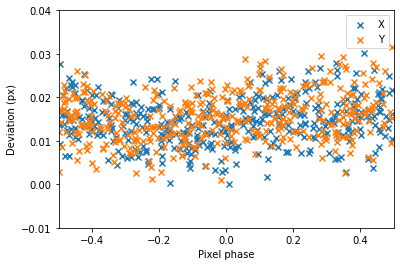

image.12.0.09.fits


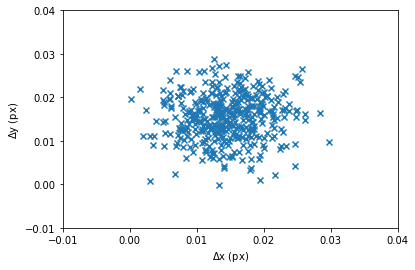

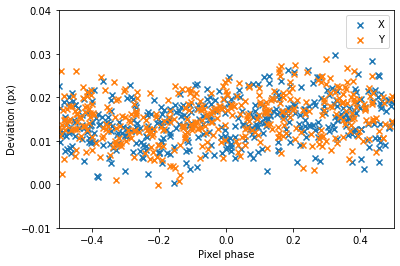

image.12.0.10.fits


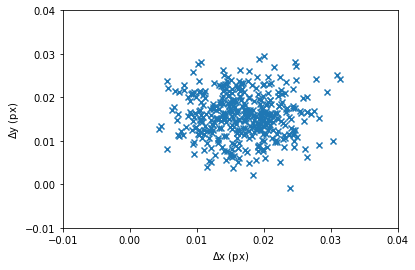

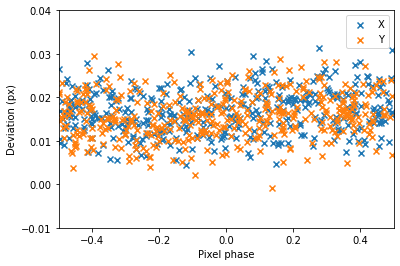

image.12.5.00.fits


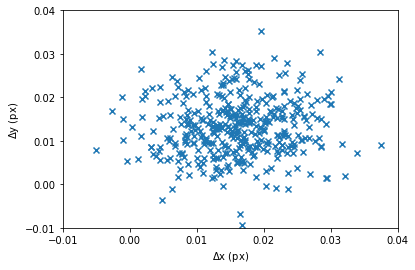

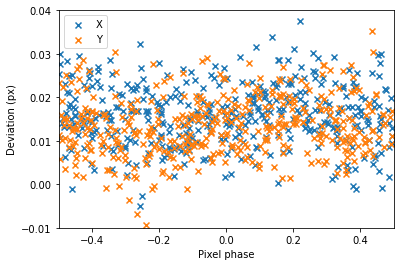

image.12.5.01.fits


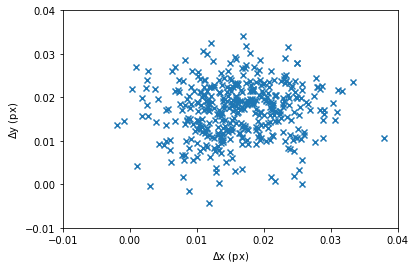

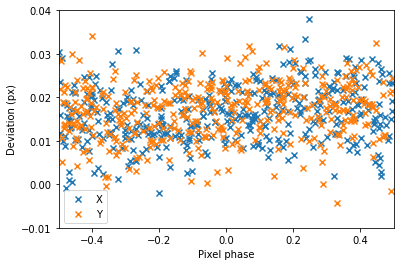

image.12.5.02.fits


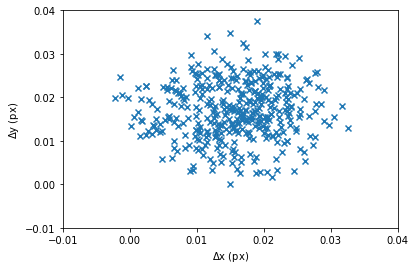

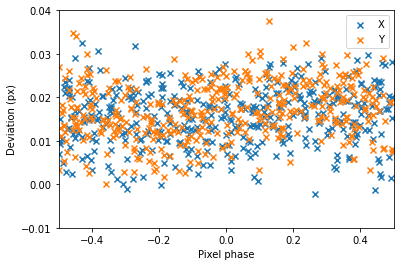

image.12.5.03.fits


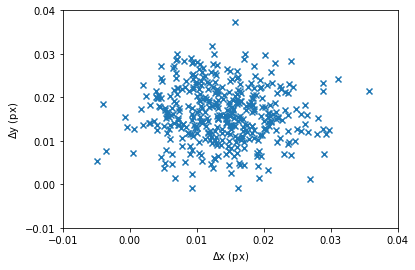

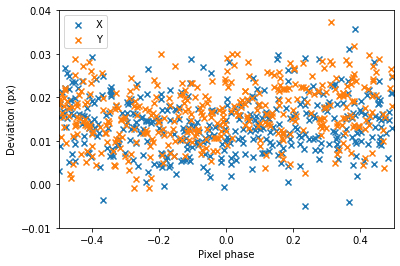

image.12.5.04.fits


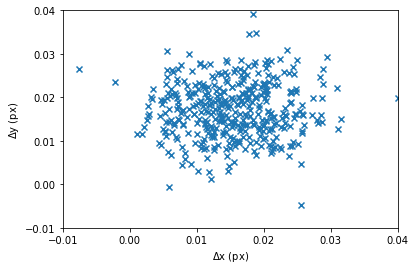

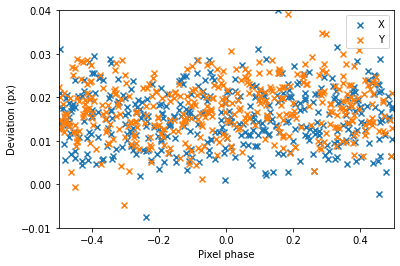

image.12.5.05.fits


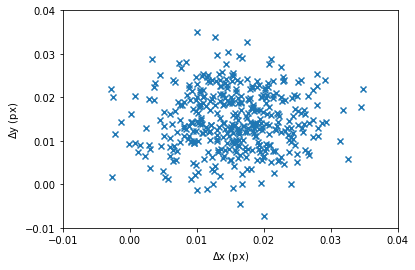

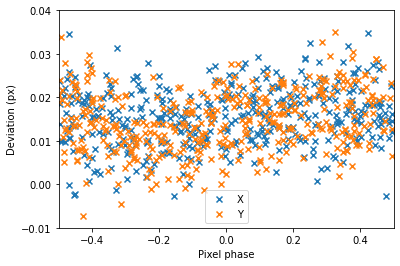

image.12.5.06.fits


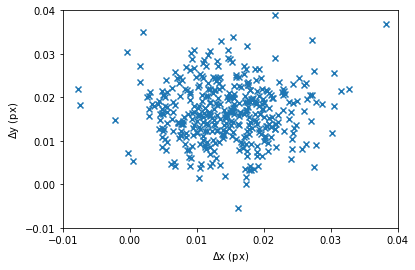

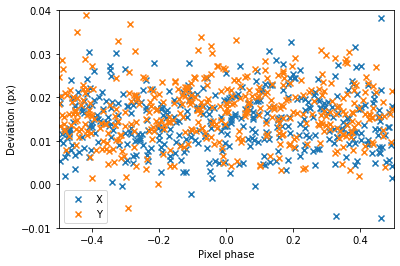

image.12.5.07.fits


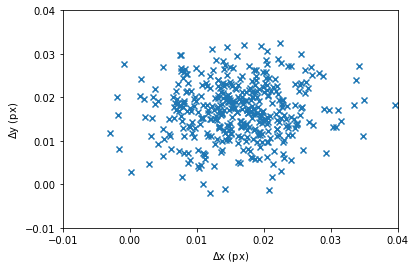

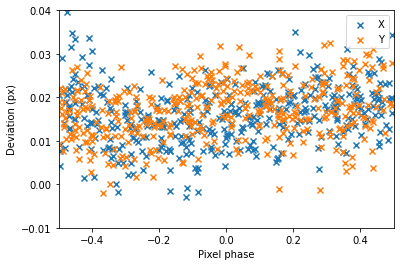

image.12.5.08.fits


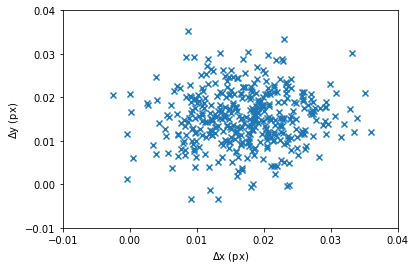

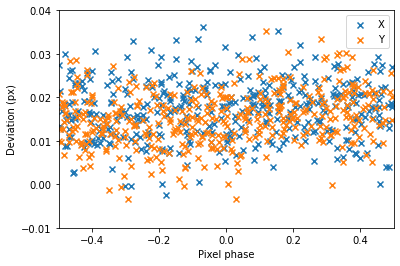

image.12.5.09.fits


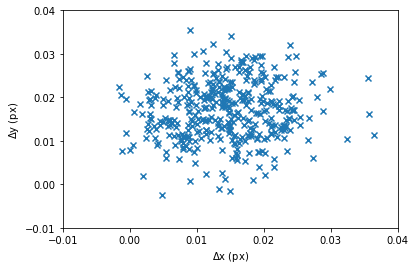

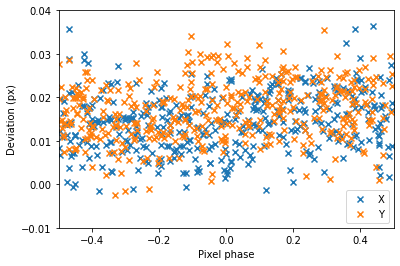

image.12.5.10.fits


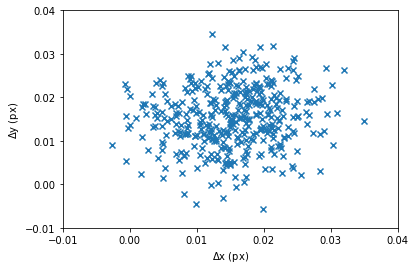

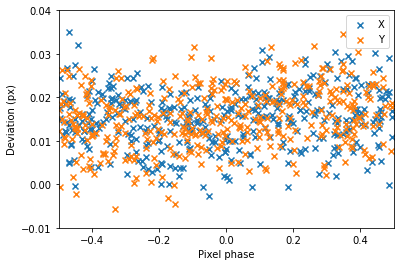

image.13.0.00.fits


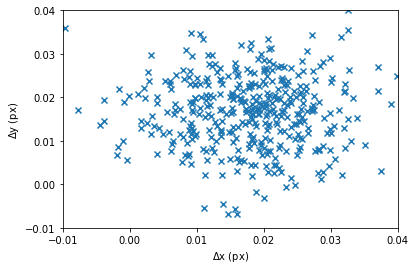

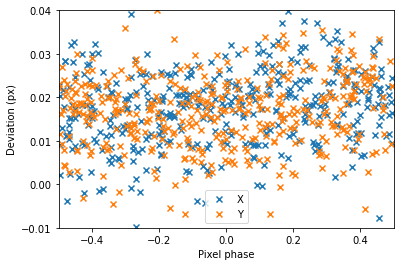

image.13.0.01.fits


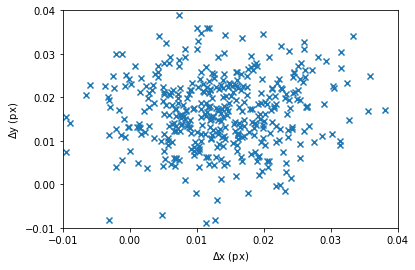

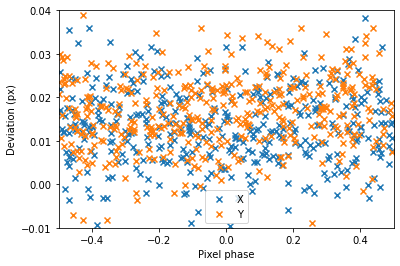

image.13.0.02.fits


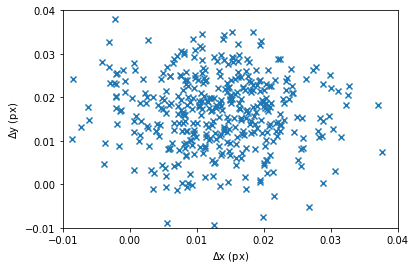

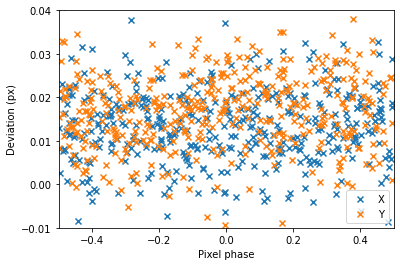

image.13.0.03.fits


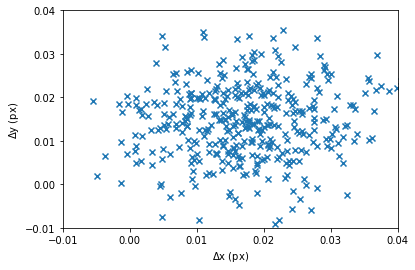

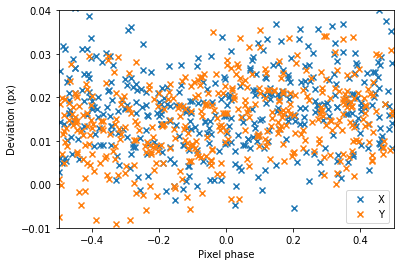

image.13.0.04.fits


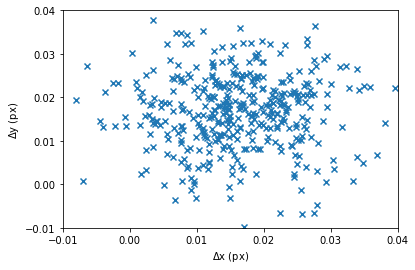

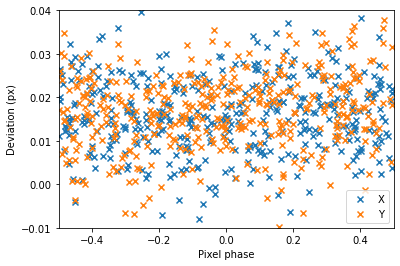

image.13.0.05.fits


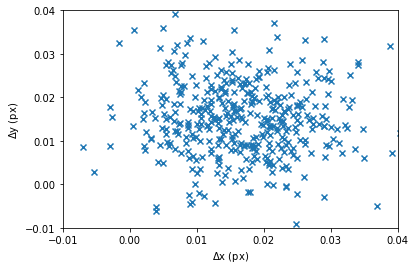

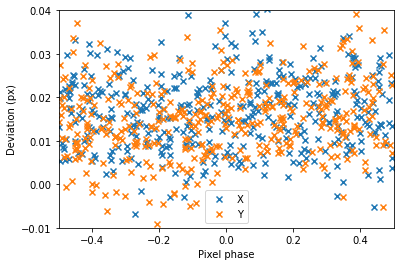

image.13.0.06.fits


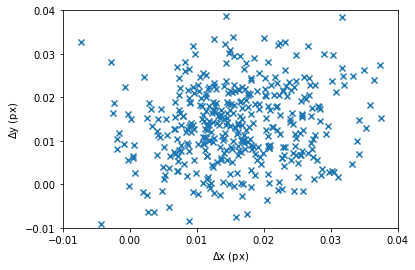

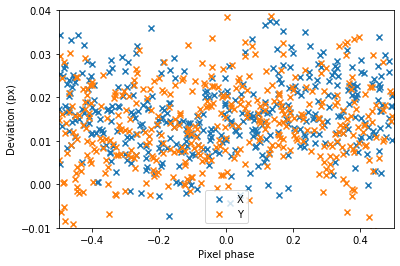

image.13.0.07.fits


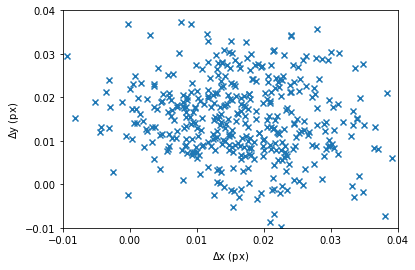

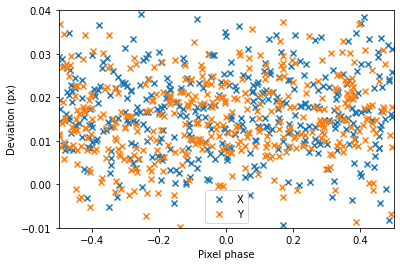

image.13.0.08.fits


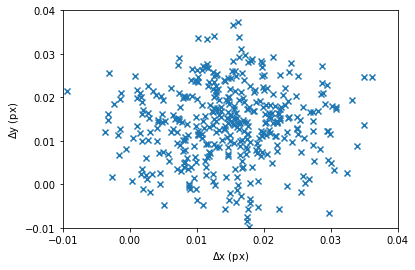

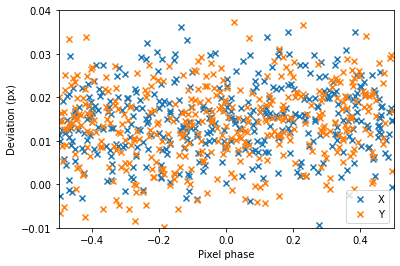

image.13.0.09.fits


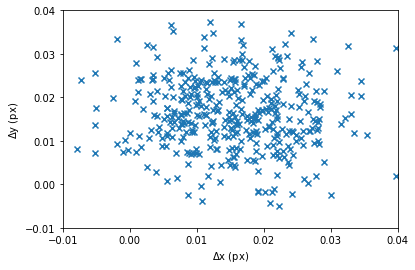

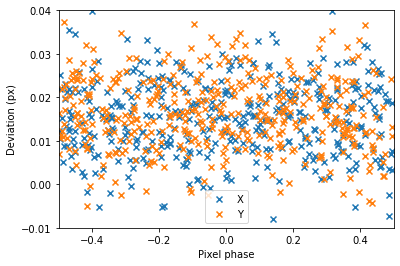

image.13.0.10.fits


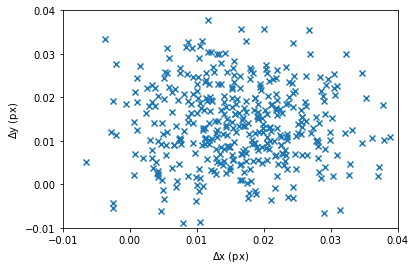

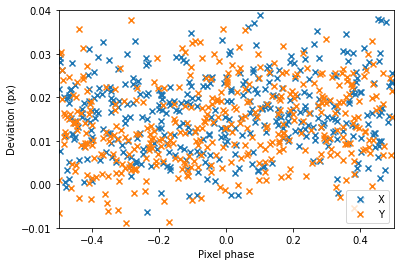

image.13.5.00.fits


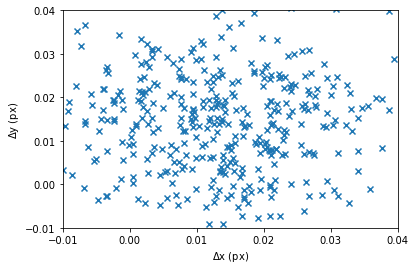

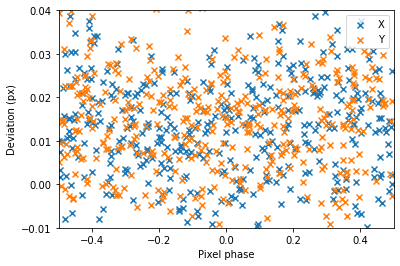

image.13.5.01.fits


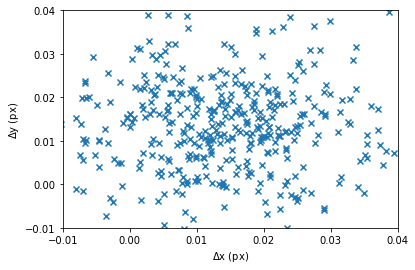

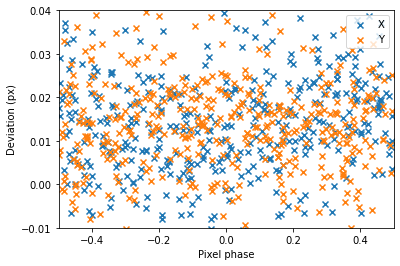

image.13.5.02.fits


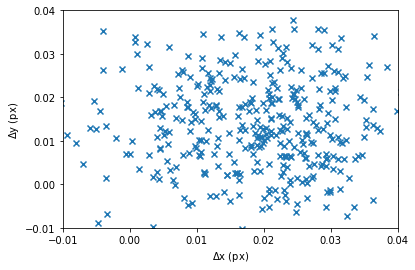

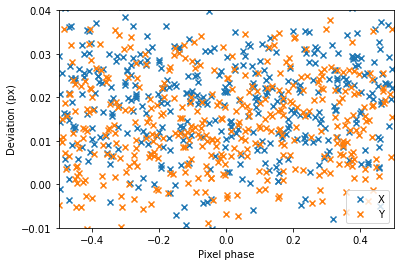

image.13.5.03.fits


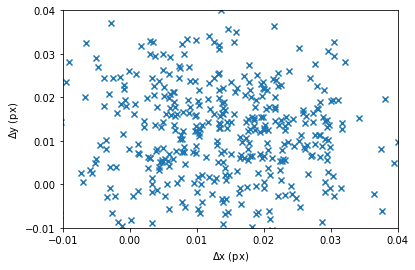

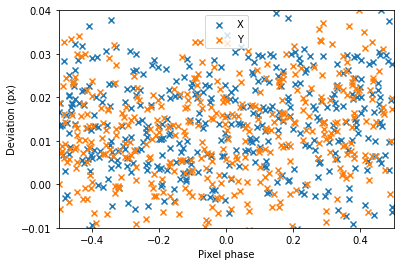

image.13.5.04.fits


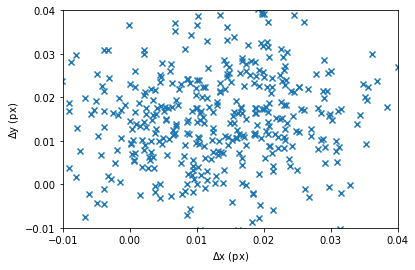

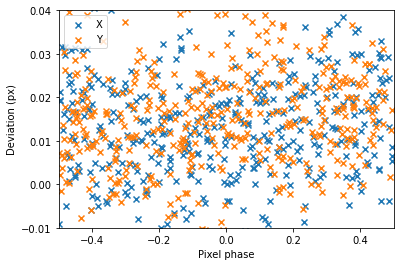

image.13.5.05.fits


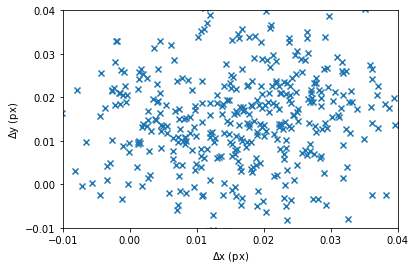

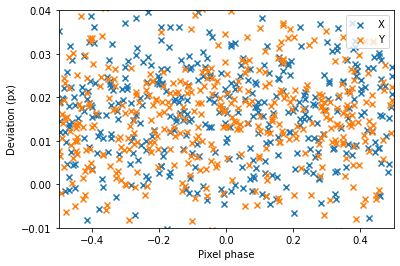

image.13.5.06.fits


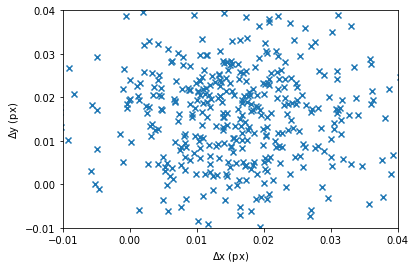

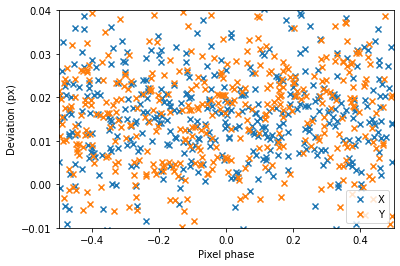

image.13.5.07.fits


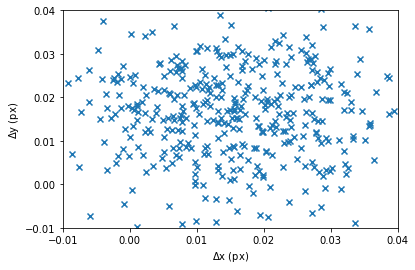

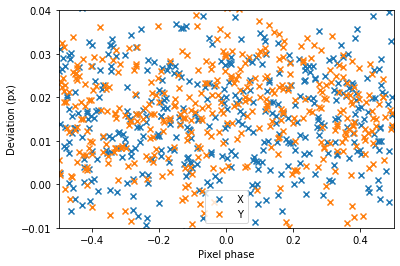

image.13.5.08.fits


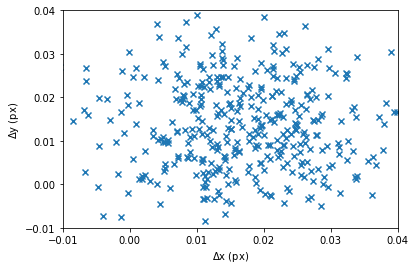

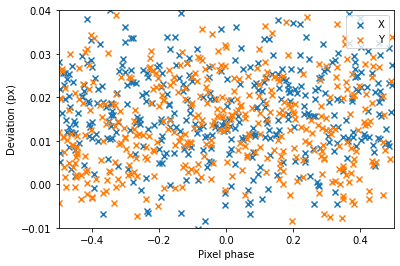

image.13.5.09.fits


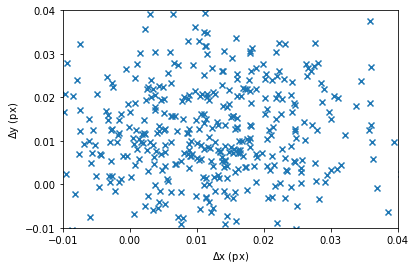

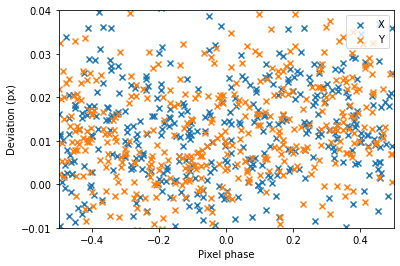

image.13.5.10.fits


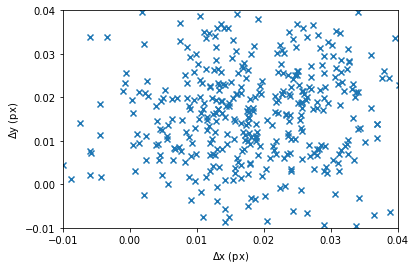

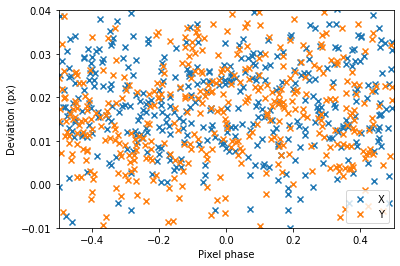

image.14.0.00.fits


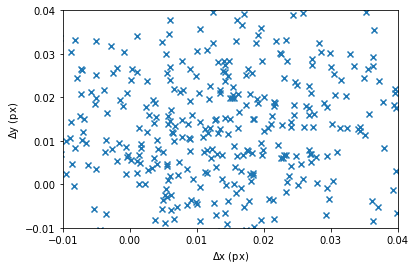

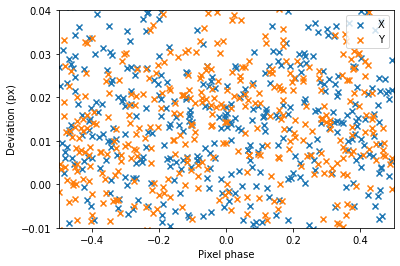

image.14.0.01.fits


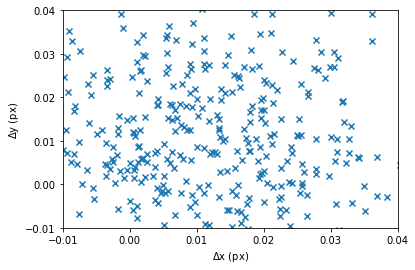

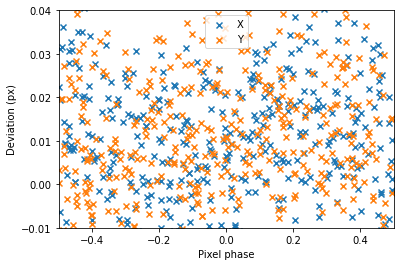

image.14.0.02.fits


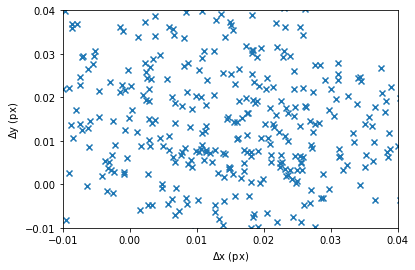

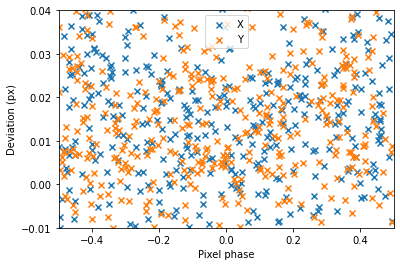

image.14.0.03.fits


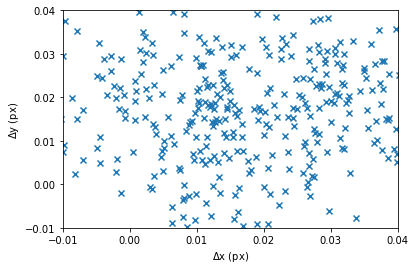

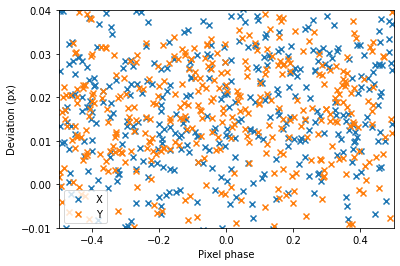

image.14.0.04.fits


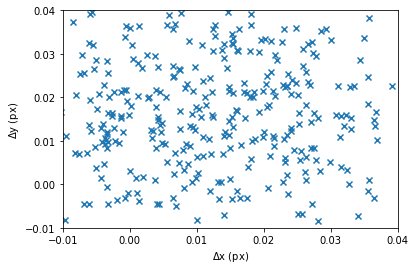

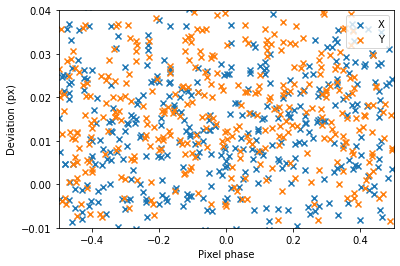

image.14.0.05.fits


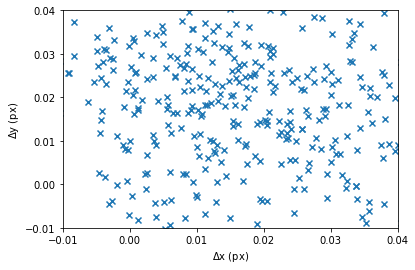

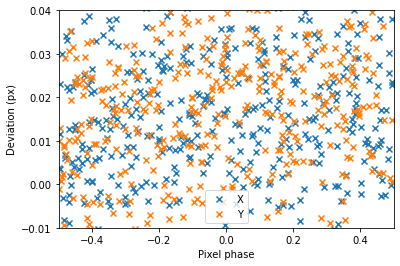

image.14.0.06.fits


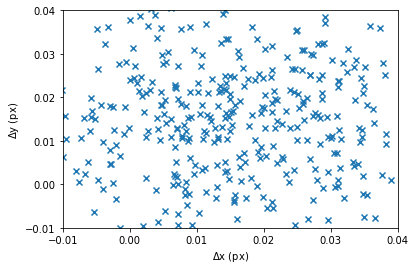

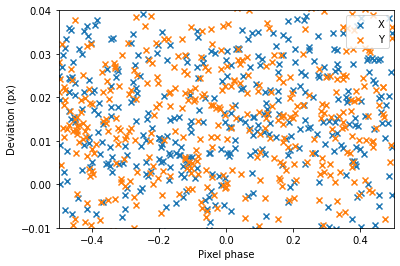

image.14.0.07.fits


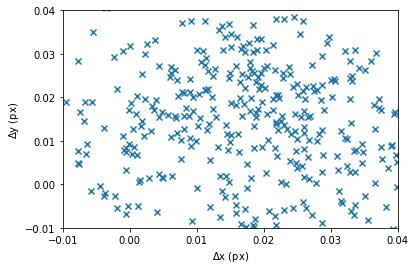

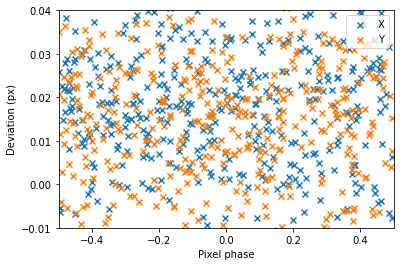

image.14.0.08.fits


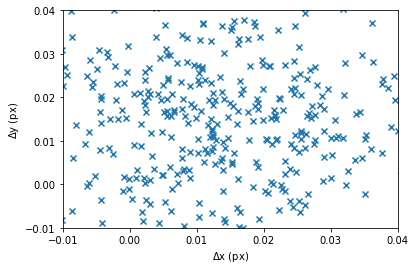

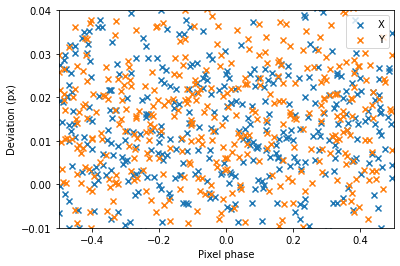

image.14.0.09.fits


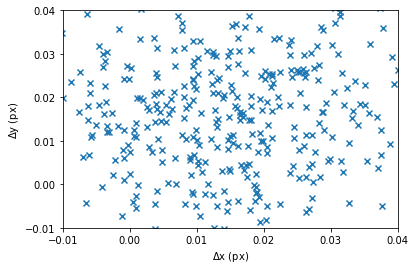

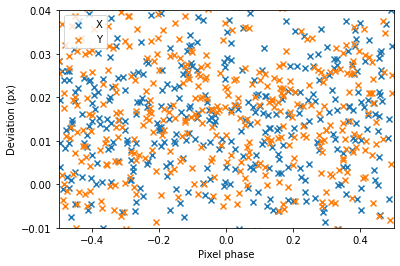

image.14.0.10.fits


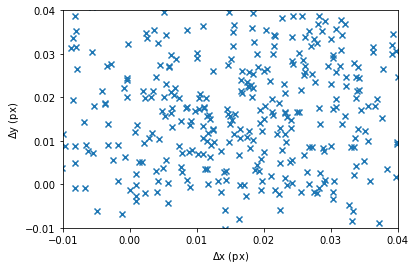

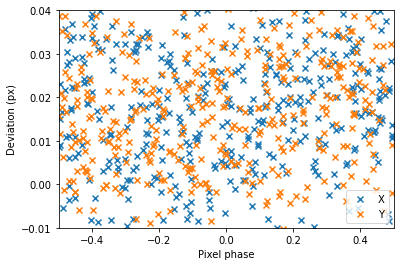

image.14.5.00.fits


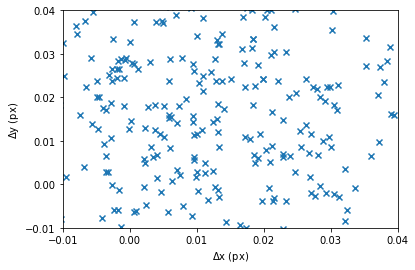

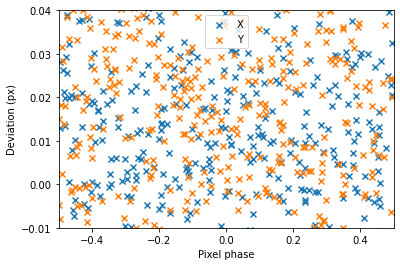

image.14.5.01.fits


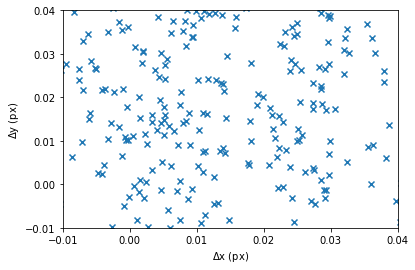

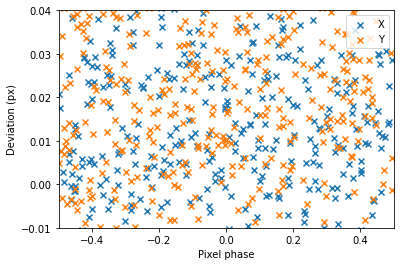

image.14.5.02.fits


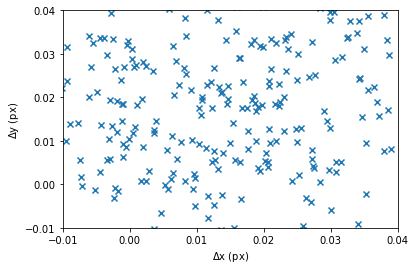

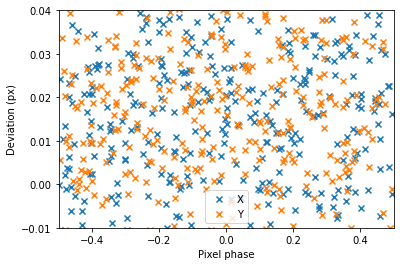

image.14.5.03.fits


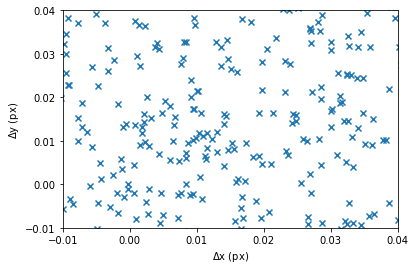

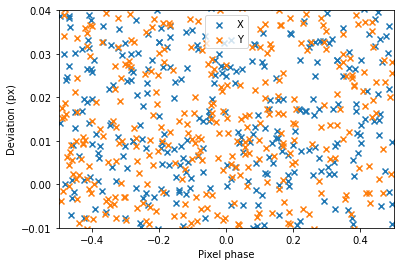

image.14.5.04.fits


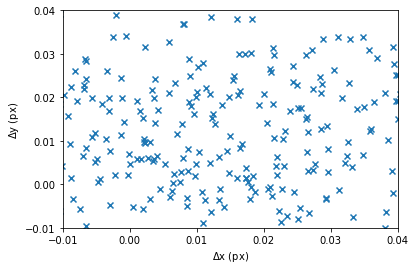

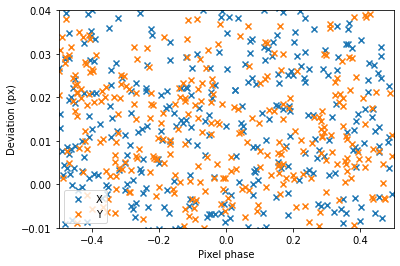

image.14.5.05.fits


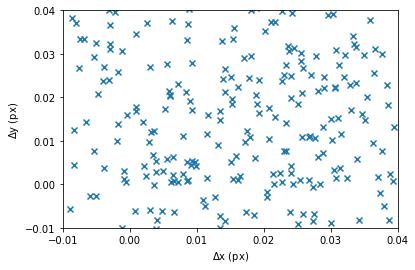

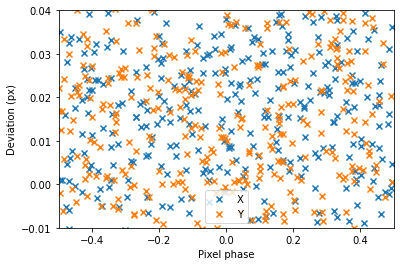

image.14.5.06.fits


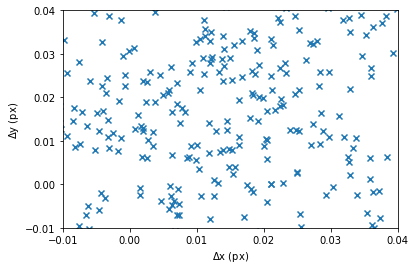

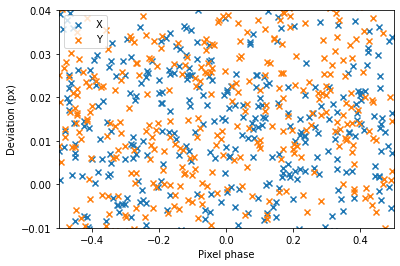

image.14.5.07.fits


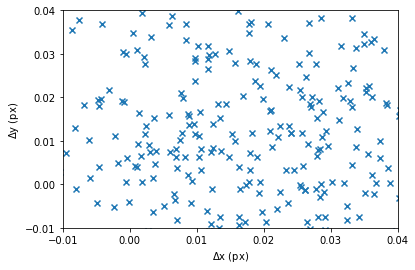

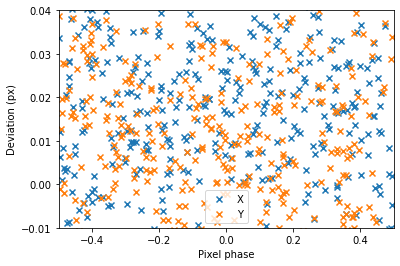

image.14.5.08.fits


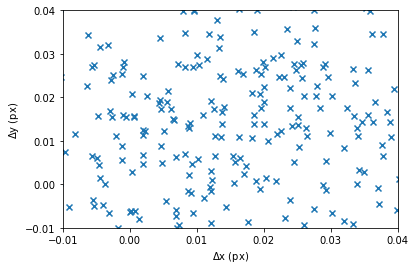

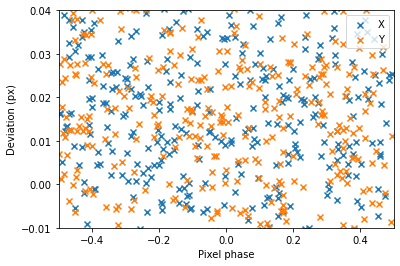

image.14.5.09.fits


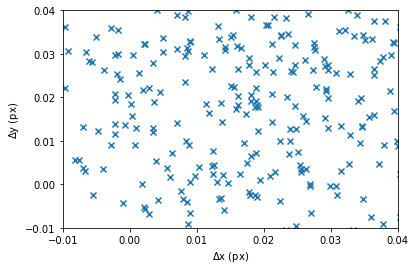

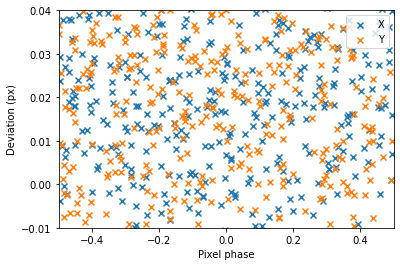

image.14.5.10.fits


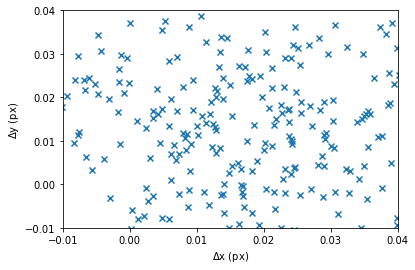

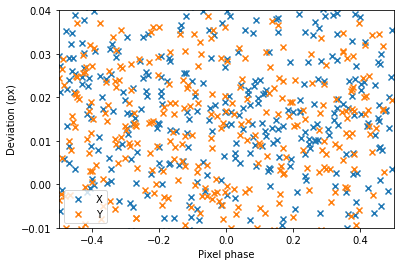

In [6]:
spname = '../01_params/spcsv_20_1920_10_20_12.0.csv'
arr = []
for mag in np.arange(12.0, 15.0, 0.5):
    tmp = []
    for i in range(0,11):
        filename = 'image.{:4.1f}.{:02d}.fits'.format(mag, i)
        print(filename)
        sx, sy, sr, mx, my, ndat = func(filename, spname, mag)
        tmp.append([sx, sy, sr])
    tmp = np.array(tmp)
    arr.append(tmp)
arr = np.array(arr)

12.0


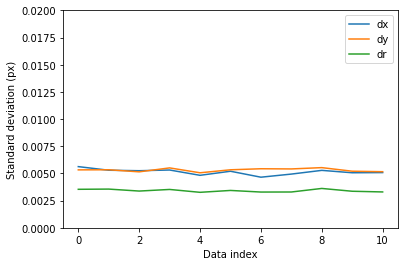

12.5


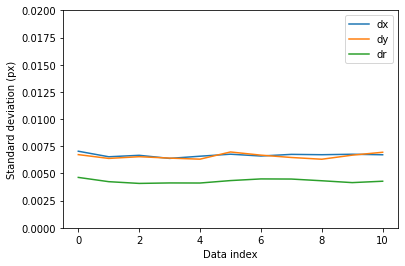

13.0


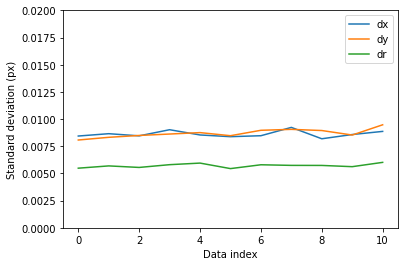

13.5


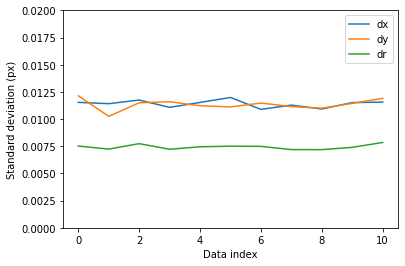

14.0


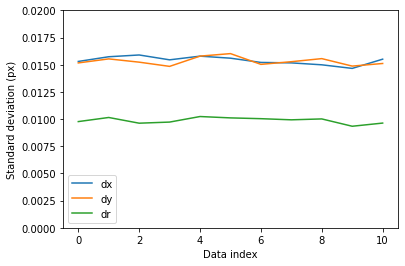

14.5


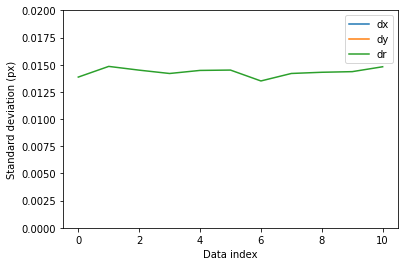

In [7]:
mags = np.arange(12.0,15.0,0.5)
arr2 = []
for i in range(6):
    print(mags[i])
    plt.plot(arr[i,:,0],label='dx')
    plt.plot(arr[i,:,1],label='dy')
    plt.plot(arr[i,:,2],label='dr')
    plt.legend()
    plt.ylim([0,0.02])
    plt.xlabel('Data index')
    plt.ylabel('Standard deviation (px)')
    plt.show()
    
    filename='data.{:4.1f}.dat'.format(mags[i])
    np.savetxt(filename, arr[i])
    
    arr2.append([mags[i], np.mean(arr[i,:,2]), np.std(arr[i,:,2],ddof=1)/np.sqrt(arr.shape[1])])
arr2 = np.array(arr2)

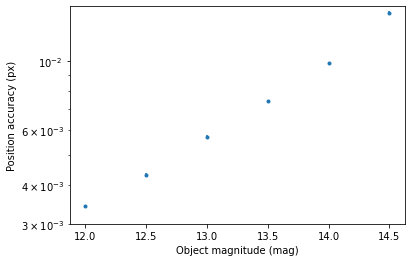

In [8]:
plt.errorbar(arr2[:,0], arr2[:,1], yerr=arr2[:,2], marker='.', linestyle="None")
plt.xlabel('Object magnitude (mag)')
plt.ylabel('Position accuracy (px)')
plt.yscale('log')
plt.ylim([3e-3,1.5e-2])
plt.show()

In [9]:
np.savetxt('data_accuracy.dat',arr2)